# S6 hardware injection recovery

Here we show the recovery of a hardware injection performed during the LIGO S6 run.

In [23]:
%matplotlib inline

import os, sys
sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import numpy as np
from scotchcorner import scotchcorner as sc
import lalapps.pulsarpputils as pppu

import subprocess as sp
import collections
import itertools

In [2]:
# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'lalapps_knope_O2' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples

In [3]:
parfile = 'PULSAR03.par'

priorfile = 'prior.txt'
priordat = """H0 uniform 0 1e-20
PHI0 uniform 0 {}
PSI uniform 0 {}
COSIOTA uniform -1 1
"""
fp = open(priorfile, 'w')
fp.write(priordat.format(np.pi, np.pi/2.))
fp.close()

datafileH1 = 'finehet_JPULSAR03_H1.gz'
datafileL1 = 'finehet_JPULSAR03_L1.gz'

Nlive = 1024

In [4]:
# run the single and multi-detector analysis

# H1
outfileH1 = 'hwinj_nest03_H1.hdf'
codecall = ' '.join([ppenexec, '--detectors', 'H1', '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafileH1, '--outfile', outfileH1,
                     '--Nlive', str(Nlive), '--Nmcmcinitial', '0'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [5]:
# L1
outfileL1 = 'hwinj03_nest_L1.hdf'
codecall = ' '.join([ppenexec, '--detectors', 'L1', '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafileL1, '--outfile', outfileL1,
                     '--Nlive', str(Nlive), '--Nmcmcinitial', '0'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [6]:
# Joint
outfilejoint = 'hwinj03_nest_Joint.hdf'
codecall = ' '.join([ppenexec, '--detectors', 'H1,L1', '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', ','.join([datafileH1, datafileL1]), '--outfile',
                     outfilejoint, '--Nlive', str(Nlive), '--Nmcmcinitial', '0'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [28]:
# convert nested samples to posterior samples
postfileH1 = 'hwinj03_post_H1.hdf'
postfileL1 = 'hwinj03_post_L1.hdf'
postfileJoint = 'hwinj03_post_Joint.hdf'

codecall = ' '.join([n2pexec, '-p', postfileH1, outfileH1])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

codecall = ' '.join([n2pexec, '-p', postfileL1, outfileL1])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

codecall = ' '.join([n2pexec, '-p', postfileJoint, outfilejoint])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [29]:
# create figure
ps = collections.OrderedDict()
ps['H0'] = r'$h_0$'
ps['COSIOTA'] = r'$\cos{\iota}$'
ps['PHI0'] = r'$\phi_0$ (rad)'
ps['PSI'] = r'$\psi$ (rad)'

# values at which the signal was injected
par = pppu.psr_par(parfile)
injvals = []
for p in ps:
    injvals.append(par[p]) 

H1samps = []
L1samps = []
Jointsamps = []
pH1, zH1, nH1 = pppu.pulsar_nest_to_posterior(postfileH1)
pL1, zL1, nL1 = pppu.pulsar_nest_to_posterior(postfileL1)
pJ, zJ, nJ = pppu.pulsar_nest_to_posterior(postfileJoint)
for i, p in enumerate(ps):
    H1samps.append(pH1[p].samples)
    L1samps.append(pL1[p].samples)
    Jointsamps.append(pJ[p].samples)

H1samps = np.array(H1samps).squeeze().T
L1samps = np.array(L1samps).squeeze().T
Jointsamps = np.array(Jointsamps).squeeze().T

Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'C21', 'PHI0VECTOR', 'PHI22', 'F1', 'FREQNUM', 'PEPOCH', 'DEC', 'PMRA', 'HPLUS', 'I31', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'PHI21', 'F1_FIXED', 'Q22', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'C21', 'PHI0VECTOR', 'PHI22', 'F1', 'FREQNUM', 'PEPOCH', 'DEC', 'PMRA', 'HPLUS', 'I31', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'PHI21', 'F1_FIXED', 'Q22', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'delt

In [30]:
# output the coherent signal versus noise odds
print("log10 Coherent signal vs noise odds = %.2f" % ((zJ-nJ)/np.log(10.)))

# output the coherent signal versus incoherent or noise odds
ifossn = [{'s': zH1, 'n': nH1}, {'s': zL1, 'n': nL1}]
combs = [list(i) for i in itertools.product(['s', 'n'], repeat=2)]
incoherentcombs = -np.inf
for comb in combs:
    combsum = 0.
    for i, cval in enumerate(comb):
        combsum += ifossn[i][cval]
    incoherentcombs = np.logaddexp(incoherentcombs, combsum)

bcins = zJ - incoherentcombs
print("log10 Coherent signal vs incoherent signal or noise odds = %.2f" % (bcins/np.log(10.)))

log10 Coherent signal vs noise odds = 6728.65
log10 Coherent signal vs incoherent signal or noise odds = 9.12


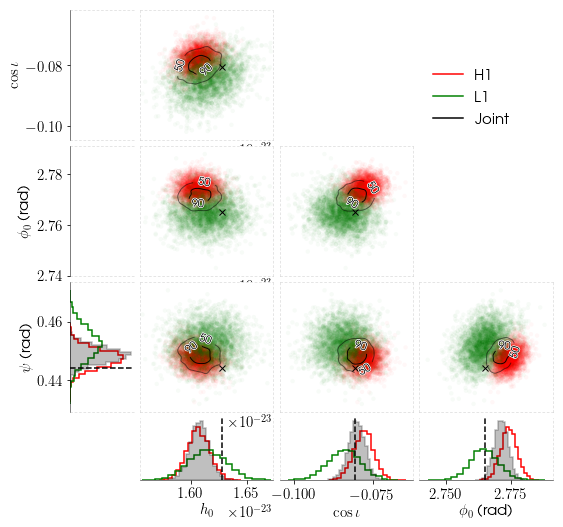

In [11]:
limits = [(None, None), (None, None), (None, None), (None, None)]

histops = {'histtype': 'step', 'color': 'r', 'edgecolor': 'r', 'linewidth': 1.5, 'alpha': 1.0}

spp = sc(H1samps, bins=20, ratio=2, labels=ps.values(), datatitle='H1', showlims='both', hist_kwargs=histops,
         showcontours=False, limits=limits, showpoints=True, scatter_kwargs={'alpha': 0.03},
         thinpoints=1)

histops = {'histtype': 'step', 'color': 'g', 'edgecolor': 'g', 'linewidth': 1.5, 'alpha': 1.0}
spp.add_data(L1samps, hist_kwargs=histops, datatitle='L1', scatter_kwargs={'alpha': 0.03}, showcontours=False,
            limits=limits)

histops = {'histtype': 'stepfilled', 'color': 'k', 'edgecolor': 'k', 'linewidth': 1.5, 'alpha': 0.25}
contourops = {'colors': 'black'}
spp.add_data(Jointsamps, hist_kwargs=histops, datatitle='Joint', scatter_kwargs={'alpha': 0.03}, showcontours=True,
             limits=limits, contour_kwargs=contourops, contour_limits=limits, truths=injvals, showpoints=False,
             truths_kwargs={'color': 'k', 'linestyle': '--'})

In [13]:
# output the plot
hwinjdir = 'hwinj03'
spp.savefig(os.path.join(hwinjdir, 'hwinj03.pdf'))
spp.fig.savefig(os.path.join(hwinjdir, 'hwinj03.png'), dpi=300)
p = sp.Popen('pdftops -eps %s' % os.path.join(hwinjdir, 'hwinj03.pdf'), shell=True)
p.communicate()

caption = r"""\label{fig:hwinj03}
Posterior probability distributions for the recovered parameters of a hardware injection (named ``Pulsar03'')
into LIGO sixth science run data. The black dashed lines and black crosses represent the expected signal
parameters.
"""

fp = open(os.path.join(hwinjdir, 'caption.tex'), 'w')
fp.write(caption)
fp.close()

Now repeat for HW injection 5

In [15]:
parfile = 'PULSAR05.par'

datafileH1 = 'finehet_JPULSAR05_H1.gz'
datafileL1 = 'finehet_JPULSAR05_L1.gz'

In [16]:
# run the single and multi-detector analysis

# H1
outfileH1 = 'hwinj_nest05_H1.hdf'
codecall = ' '.join([ppenexec, '--detectors', 'H1', '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafileH1, '--outfile', outfileH1,
                     '--Nlive', str(Nlive), '--Nmcmcinitial', '0'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [17]:
# L1
outfileL1 = 'hwinj05_nest_L1.hdf'
codecall = ' '.join([ppenexec, '--detectors', 'L1', '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafileL1, '--outfile', outfileL1,
                     '--Nlive', str(Nlive), '--Nmcmcinitial', '0'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [18]:
# Joint
outfilejoint = 'hwinj05_nest_Joint.hdf'
codecall = ' '.join([ppenexec, '--detectors', 'H1,L1', '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', ','.join([datafileH1, datafileL1]), '--outfile',
                     outfilejoint, '--Nlive', str(Nlive), '--Nmcmcinitial', '0'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [19]:
# convert nested samples to posterior samples
postfileH1 = 'hwinj05_post_H1.hdf'
postfileL1 = 'hwinj05_post_L1.hdf'
postfileJoint = 'hwinj05_post_Joint.hdf'

codecall = ' '.join([n2pexec, '-p', postfileH1, outfileH1])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

codecall = ' '.join([n2pexec, '-p', postfileL1, outfileL1])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

codecall = ' '.join([n2pexec, '-p', postfileJoint, outfilejoint])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [26]:
# create figure
ps = collections.OrderedDict()
ps['H0'] = r'$h_0$'
ps['COSIOTA'] = r'$\cos{\iota}$'
ps['PHI0'] = r'$\phi_0$ (rad)'
ps['PSI'] = r'$\psi$ (rad)'

# values at which the signal was injected
par = pppu.psr_par(parfile)
injvals = []
for p in ps:
    injvals.append(par[p]) 

H1samps2 = []
L1samps2 = []
Jointsamps2 = []
pH1, zH1, nH1 = pppu.pulsar_nest_to_posterior(postfileH1)
pL1, zL1, nL1 = pppu.pulsar_nest_to_posterior(postfileL1)
pJ, zJ, nJ = pppu.pulsar_nest_to_posterior(postfileJoint)
for i, p in enumerate(ps):
    H1samps2.append(pH1[p].samples)
    L1samps2.append(pL1[p].samples)
    Jointsamps2.append(pJ[p].samples)

H1samps2 = np.array(H1samps2).squeeze().T
L1samps2 = np.array(L1samps2).squeeze().T
Jointsamps2 = np.array(Jointsamps2).squeeze().T

Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'C21', 'PHI0VECTOR', 'PHI22', 'F1', 'FREQNUM', 'PEPOCH', 'DEC', 'PMRA', 'HPLUS', 'I31', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'PHI21', 'F1_FIXED', 'Q22', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'C21', 'PHI0VECTOR', 'PHI22', 'F1', 'FREQNUM', 'PEPOCH', 'DEC', 'PMRA', 'HPLUS', 'I31', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'PHI21', 'F1_FIXED', 'Q22', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'delt

In [27]:
# output the coherent signal versus noise odds
print("log10 Coherent signal vs noise odds = %.2f" % ((zJ-nJ)/np.log(10.)))

# output the coherent signal versus incoherent or noise odds
ifossn = [{'s': zH1, 'n': nH1}, {'s': zL1, 'n': nL1}]
combs = [list(i) for i in itertools.product(['s', 'n'], repeat=2)]
incoherentcombs = -np.inf
for comb in combs:
    combsum = 0.
    for i, cval in enumerate(comb):
        combsum += ifossn[i][cval]
    incoherentcombs = np.logaddexp(incoherentcombs, combsum)

bcins = zJ - incoherentcombs
print("log10 Coherent signal vs incoherent signal or noise odds = %.2f" % (bcins/np.log(10.)))

log10 Coherent signal vs noise odds = 22.46
log10 Coherent signal vs incoherent signal or noise odds = 4.63


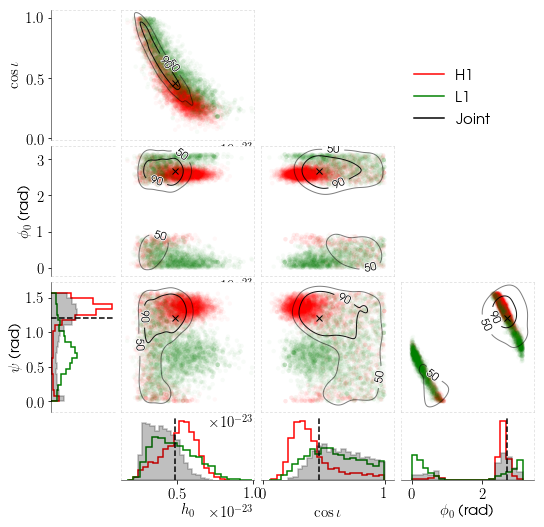

In [21]:
limits = [(None, None), (None, None), (None, None), (None, None)]

histops = {'histtype': 'step', 'color': 'r', 'edgecolor': 'r', 'linewidth': 1.5, 'alpha': 1.0}

spp = sc(H1samps2, bins=20, ratio=2, labels=ps.values(), datatitle='H1', showlims='both', hist_kwargs=histops,
         showcontours=False, limits=limits, showpoints=True, scatter_kwargs={'alpha': 0.03},
         thinpoints=1)

histops = {'histtype': 'step', 'color': 'g', 'edgecolor': 'g', 'linewidth': 1.5, 'alpha': 1.0}
spp.add_data(L1samps2, hist_kwargs=histops, datatitle='L1', scatter_kwargs={'alpha': 0.03}, showcontours=False,
            limits=limits)

histops = {'histtype': 'stepfilled', 'color': 'k', 'edgecolor': 'k', 'linewidth': 1.5, 'alpha': 0.25}
contourops = {'colors': 'black'}
spp.add_data(Jointsamps2, hist_kwargs=histops, datatitle='Joint', scatter_kwargs={'alpha': 0.03}, showcontours=True,
             limits=limits, contour_kwargs=contourops, contour_limits=limits, truths=injvals, showpoints=False,
             truths_kwargs={'color': 'k', 'linestyle': '--'})

In [31]:
# output the plot
hwinjdir = 'hwinj05'
spp.savefig(os.path.join(hwinjdir, 'hwinj05.pdf'))
spp.fig.savefig(os.path.join(hwinjdir, 'hwinj05.png'), dpi=300)
p = sp.Popen('pdftops -eps %s' % os.path.join(hwinjdir, 'hwinj03.pdf'), shell=True)
p.communicate()

caption = r"""\label{fig:hwinj03}
Posterior probability distributions for the recovered parameters of a hardware injection (named ``Pulsar05'')
into LIGO sixth science run data. The black dashed lines and black crosses represent the expected signal
parameters. Note that the probability contours for the joint detector analysis, in particular for the $\phi_0$
versus $\psi$ plot, are broader than the true distributions due to the smoothing kernel not handling the
parameter degeneracy well.
"""

fp = open(os.path.join(hwinjdir, 'caption.tex'), 'w')
fp.write(caption)
fp.close()